In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [2]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.15.0
Version 2, minor 15


Derived from

Keras blog: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Mount my Google Drive (have data stored there)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Download the Cats and Dogs dataset

- The raw dataset comes from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) and is quite a large archive file.  We only need one file
  - train.zip

- A **subset** of the training data was created, and organized as described [here](https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975)
  - Only 1000 training examples, 400 validation examples, per animal type
  - The notebook "Dogs_and_Cats_reformat" will perform this reformatting
- The reformatted, subset of the dataset (much smaller) was placed in an archive, which is read in this step



Unzip the Cats and Dogs images into pwd (i.e., /content).  That is where the code is looking


In [5]:
import os
!pwd

data_dir="data"
os.makedirs(data_dir, exist_ok=True)


if not (os.path.isdir("train") and os.path.isdir("validation") ):
  %cd $data_dir
  !tar -zxvf '/content/gdrive/My Drive/data/cats_and_dogs/cats_v_dogs.tgz'
  %cd ..


/content
/content/data
./
./validation/
./validation/dogs/
./validation/dogs/dog.1302.jpg
./validation/dogs/dog.1242.jpg
./validation/dogs/dog.1108.jpg
./validation/dogs/dog.1088.jpg
./validation/dogs/dog.1140.jpg
./validation/dogs/dog.1357.jpg
./validation/dogs/dog.1194.jpg
./validation/dogs/dog.1162.jpg
./validation/dogs/dog.1219.jpg
./validation/dogs/dog.1142.jpg
./validation/dogs/dog.1005.jpg
./validation/dogs/dog.1138.jpg
./validation/dogs/dog.1293.jpg
./validation/dogs/dog.1382.jpg
./validation/dogs/dog.1331.jpg
./validation/dogs/dog.1389.jpg
./validation/dogs/dog.1154.jpg
./validation/dogs/dog.1375.jpg
./validation/dogs/dog.1352.jpg
./validation/dogs/dog.1244.jpg
./validation/dogs/dog.1325.jpg
./validation/dogs/dog.1329.jpg
./validation/dogs/dog.1322.jpg
./validation/dogs/dog.1304.jpg
./validation/dogs/dog.1183.jpg
./validation/dogs/dog.1363.jpg
./validation/dogs/dog.1393.jpg
./validation/dogs/dog.1012.jpg
./validation/dogs/dog.1240.jpg
./validation/dogs/dog.1009.jpg
./validatio

The following is from [Blog script 1](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)

# Utility routines
Based on:  https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

def plot_training(history):
  """
  Plot training and validation statistics
  - accuracy vs epoch number
  - loss     vs epoch number

  From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
  """

  # Accuracy
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  # Loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [7]:
import re
import IPython

def trainModel(model, train_data_dir, validation_data_dir):
  # compile the model with a SGD/momentum optimizer
  # and a very slow learning rate.
  model.compile(loss='binary_crossentropy',
                #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                metrics=['acc'])

  # prepare data augmentation configuration
  train_datagen = ImageDataGenerator(
      rescale=1. / 255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(rescale=1. / 255)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='binary')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='binary')

  es_callback = EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  callbacks = [ es_callback,
                    # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
                ]
  # fine-tune the model
  history = model.fit_generator(
      train_generator,
      # samples_per_epoch=nb_train_samples,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      callbacks=callbacks
      )


  return history

def createTransferModel(base_model, last_base_layer_name, down_conv_features=32):
  model = Sequential()

  # Find the last layer
  layer_names = [ l.name for l in base_model.layers ]
  last_base_layer_idx = layer_names.index(last_base_layer_name)

  print("Last layer {ll:s} is index {i:d}".format(ll=last_base_layer_name, i=last_base_layer_idx))
  for i, layer in enumerate(base_model.layers[:last_base_layer_idx+1]):
    model.add(layer)
    layer.trainable=False

  # Add down sampling
  model.add( Conv2D(down_conv_features, kernel_size=(1, 1), activation='relu') )

  # Add head
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))


  return model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile

# Problem description
- Binary classification problem, with small quantity of training data

- Cats and Dogs dataset:
  - a *small* number of examples
  - two classes: Cats, Dogs

Plan
1. Create and train own model
1. Transfer Learning
  - use the prefix of a pre-trained model
  - add own suffix
  

In [8]:
'''This script goes along the blog post
"Building powerful image classification models using very little data"
from blog.keras.io.
It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''

# dimensions of our images.
img_width, img_height = 150, 150
image_size = 150
IMG_SHAPE = (image_size, image_size, 3)

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16


def createFirstModel():
  if tf.keras.backend.image_data_format() == 'channels_first':
      input_shape = (3, img_width, img_height)
  else:
      input_shape = (img_width, img_height, 3)

  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model


# Create own model
- multiple Conv2D/Pooling blocks


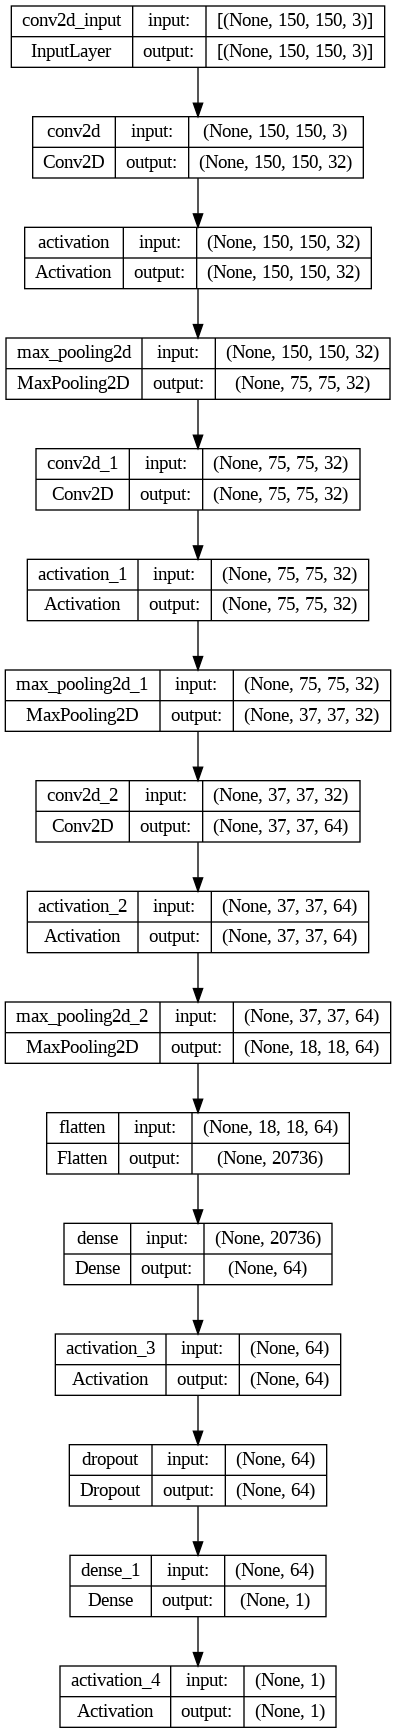

In [9]:
first_model = createFirstModel()
plotFile = plotModel(first_model, "first_model")
IPython.display.Image( plotFile)


In [10]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 75, 75, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                   

In [26]:
first_history = trainModel(first_model, train_data_dir, validation_data_dir  )

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50


<ipython-input-7-3bed2bd7014a>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


125/125 [==============================] - 16s 120ms/step - loss: 0.6926 - acc: 0.5500 - val_loss: 0.6738 - val_acc: 0.5487
Epoch 2/50
125/125 [==============================] - 15s 119ms/step - loss: 0.6674 - acc: 0.6200 - val_loss: 0.7360 - val_acc: 0.5462
Epoch 3/50
125/125 [==============================] - 15s 121ms/step - loss: 0.6371 - acc: 0.6325 - val_loss: 0.6293 - val_acc: 0.6112
Epoch 4/50
125/125 [==============================] - 15s 119ms/step - loss: 0.6172 - acc: 0.6710 - val_loss: 0.6059 - val_acc: 0.6500
Epoch 5/50
125/125 [==============================] - 15s 119ms/step - loss: 0.5978 - acc: 0.6855 - val_loss: 0.5978 - val_acc: 0.6687
Epoch 6/50
125/125 [==============================] - 15s 119ms/step - loss: 0.5938 - acc: 0.6935 - val_loss: 0.5653 - val_acc: 0.7312
Epoch 7/50
125/125 [==============================] - 15s 119ms/step - loss: 0.5750 - acc: 0.6955 - val_loss: 0.5346 - val_acc: 0.7412
Epoch 8/50
125/125 [==============================] - 15s 118ms/st

In [27]:
first_model.save_weights('first_try.h5')

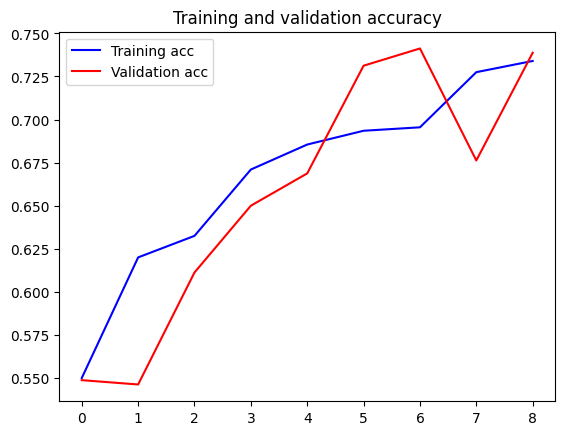

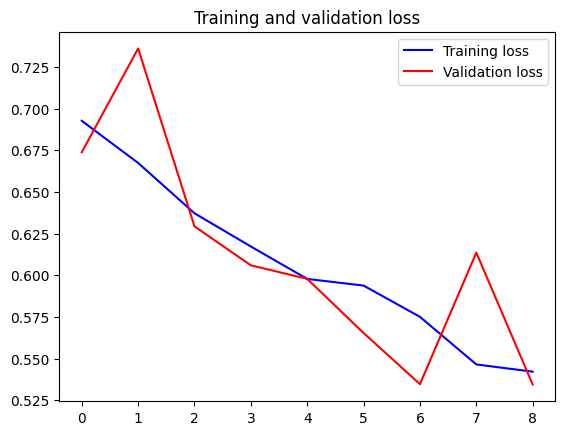

In [28]:
plot_training(first_history)

In [14]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

def show_errors(model, data_generator, data_dir, start=0, end=None):
  """
  Show misclassified images

  Adapted from: https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

  data_generator generates images to classify
  - n.b., shuffle=False should be set when constructing this generator
  --- this is b/c when we ask the generator for .filenames and .classes  it is deterministic
  ---- the .classes form the "ground truth" against which predictions are evaluated so the order of examples must be deterministic
  Parameters
  -----------
  model: model for prediction
  data_generator: generator for data
  data_dir: the directory from which the generator obtains its data
  start, end: Integers.  Indices for first and last error (first error is 0)
  """

  # Get the filenames from the generator
  fnames = data_generator.filenames

  # Get the ground truth from generator
  ground_truth = data_generator.classes

  # Get the label to class mapping from the generator
  # i.e., { "class 0": 0, "class 1": 1, ... }
  label2index = xvalidation_generator.class_indices

  # Getting the mapping from class index to class label
  idx2label = dict((v,k) for k,v in label2index.items())

  # Get the predictions from the model using the generator
  predictions = model.predict_generator(data_generator, steps=data_generator.samples/data_generator.batch_size,verbose=1)

  # Handle special case where prediction is binary, not categorical
  # convert it into 2 categories
  if predictions.shape[-1] == 1:
    predictions = np.c_[ 1-predictions, predictions]

  predicted_classes = np.argmax(predictions,axis=1)

  # errors: list of indices where prediction is wrong
  errors = np.where(predicted_classes != ground_truth)[0]
  print("No of errors = {}/{}".format(len(errors),data_generator.samples))

  if end is None:
    end = len(errors)

  # Show the errors
  for i in range(start, end):
      pred_class = np.argmax(predictions[errors[i]])
      pred_label = idx2label[pred_class]

      title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
          fnames[errors[i]].split('/')[0],
          pred_label,
          predictions[errors[i]][pred_class])

      original = load_img('{}/{}'.format(data_dir,fnames[errors[i]]))
      plt.figure(figsize=[7,7])
      plt.axis('off')
      plt.title(title)
      plt.imshow(original)
      plt.show()


Found 800 images belonging to 2 classes.


<ipython-input-14-25b8f1a6f66a>:36: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(data_generator, steps=data_generator.samples/data_generator.batch_size,verbose=1)


50/50 [==============================] - 2s 30ms/step
No of errors = 305/800


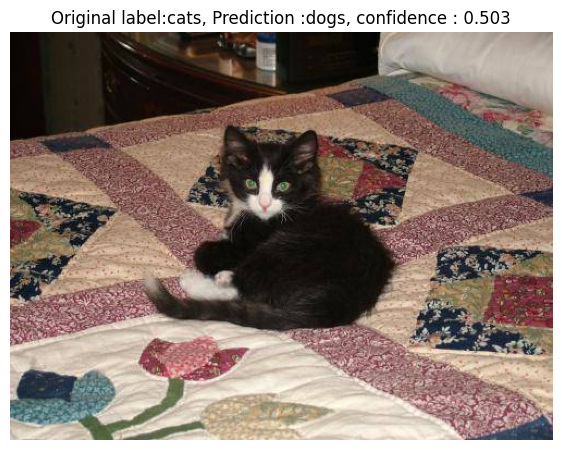

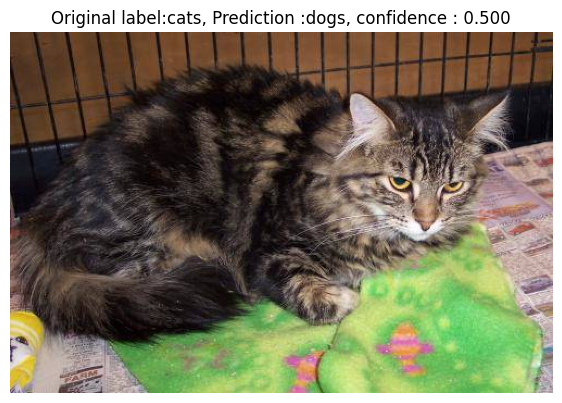

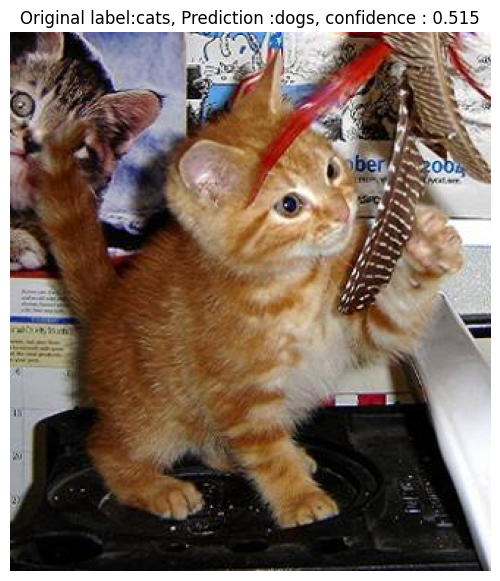

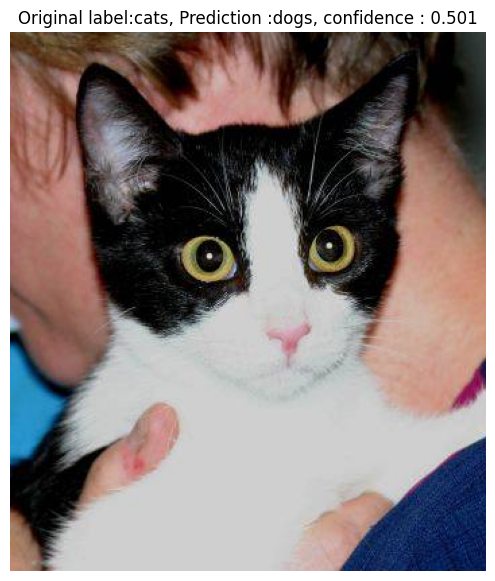

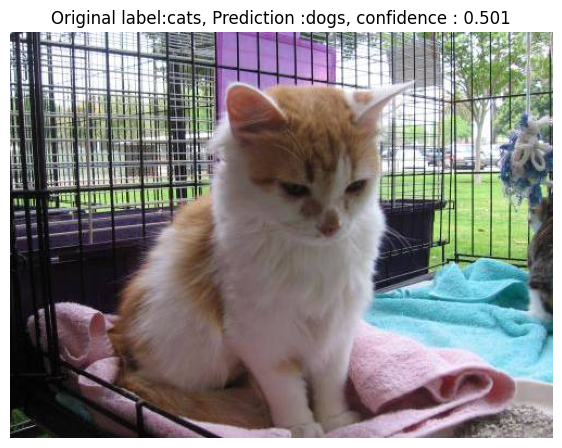

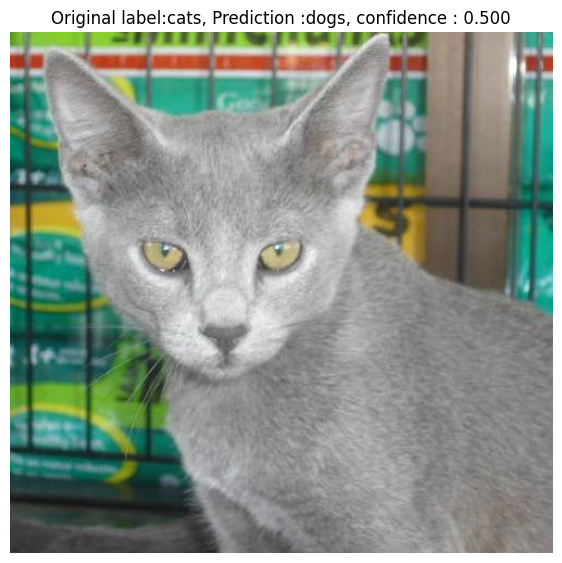

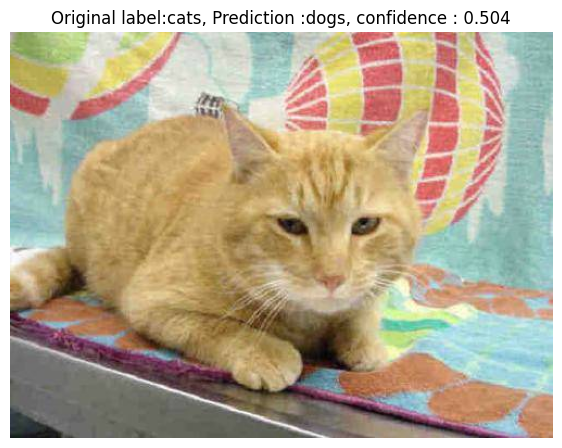

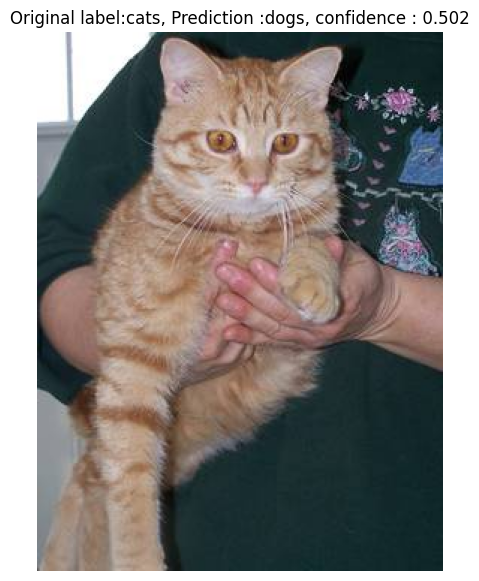

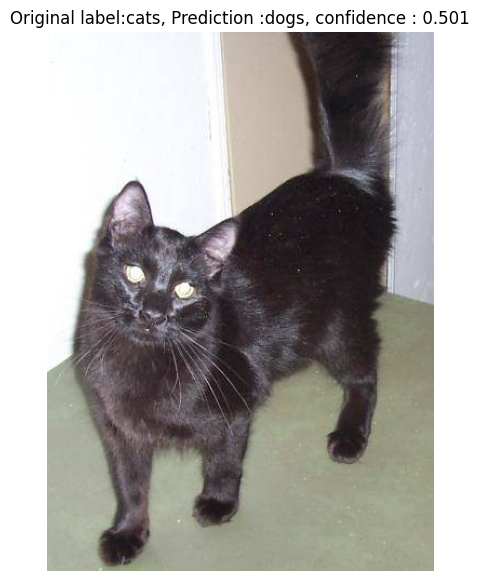

In [15]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Need validation set to NOT be shuffled
#- n.b., shuffle=False should be set when constructing this generator
#  --- this is b/c when we ask the generator for .filenames and .classes  it is deterministic
#  ---- the .classes form the "ground truth" against which predictions are evaluated so the order of examples must be deterministic
xvalidation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

show_errors(first_model, xvalidation_generator, validation_data_dir, start=1, end=10)

# Load a pre-trained VGG16 model

58889256/58889256 [==============================] - 0s 0us/step


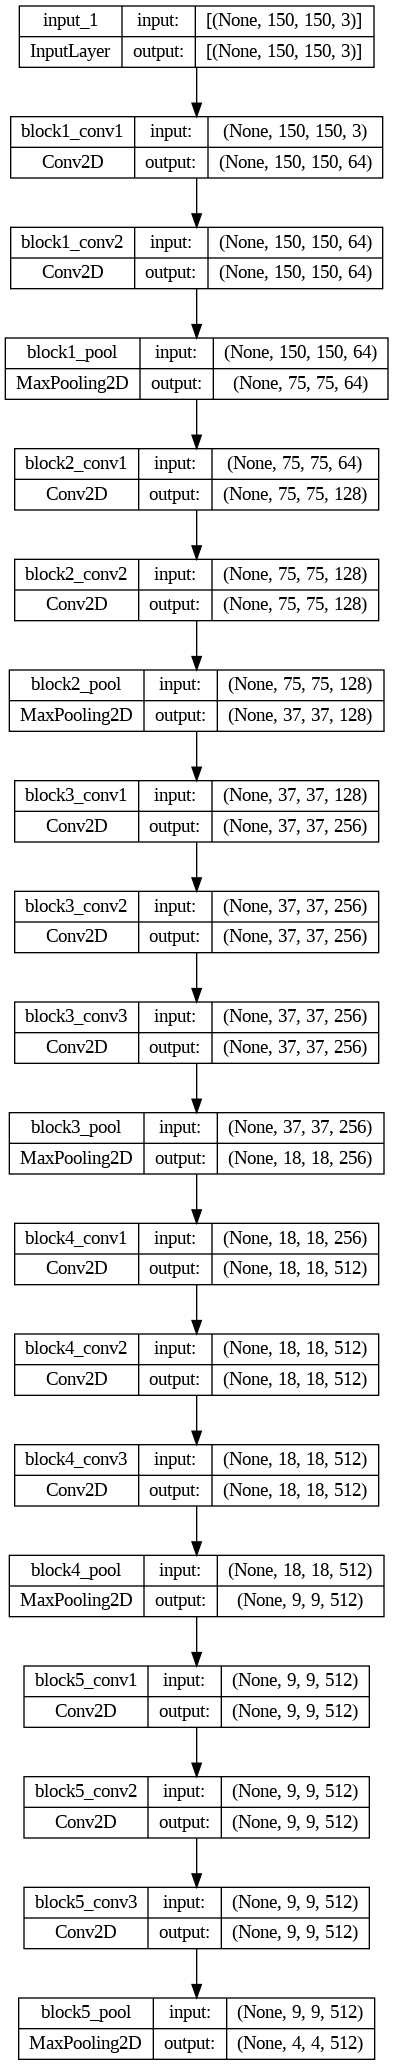

In [16]:
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                     include_top=False,
                                     weights='imagenet')

plotFile = plotModel(base_model, "vgg16_model")
IPython.display.Image( plotFile)



In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# Transfer Learning: Graft a new head onto VGG 16

In [18]:
transf_model = createTransferModel(base_model,  base_model.layers[-1].name)
transf_model.summary()

Last layer block5_pool is index 18
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50


<ipython-input-7-3bed2bd7014a>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


125/125 [==============================] - 21s 144ms/step - loss: 0.4980 - acc: 0.7535 - val_loss: 0.3098 - val_acc: 0.8637
Epoch 2/50
125/125 [==============================] - 18s 144ms/step - loss: 0.3619 - acc: 0.8450 - val_loss: 0.2903 - val_acc: 0.8838
Epoch 3/50
125/125 [==============================] - 17s 135ms/step - loss: 0.3274 - acc: 0.8615 - val_loss: 0.2464 - val_acc: 0.9025
Epoch 4/50
125/125 [==============================] - 18s 144ms/step - loss: 0.2819 - acc: 0.8795 - val_loss: 0.2266 - val_acc: 0.9062
Epoch 5/50
125/125 [==============================] - 18s 142ms/step - loss: 0.2544 - acc: 0.9030 - val_loss: 0.2343 - val_acc: 0.9075
Epoch 6/50
125/125 [==============================] - 17s 136ms/step - loss: 0.2401 - acc: 0.9080 - val_loss: 0.2397 - val_acc: 0.9062


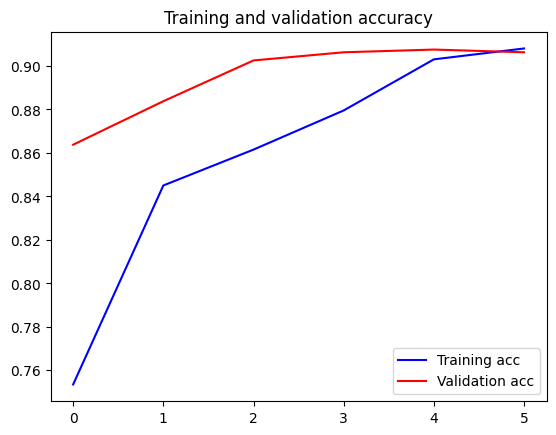

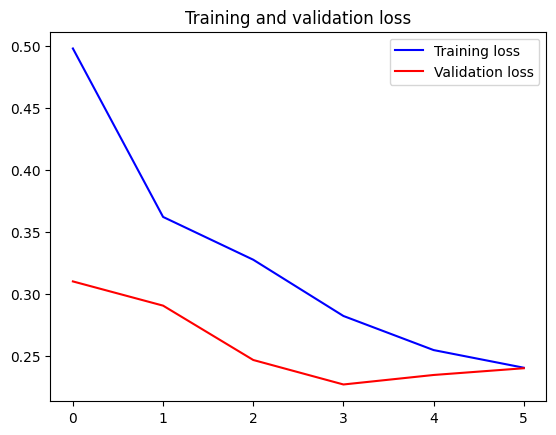

In [19]:
transf_history = trainModel(transf_model, train_data_dir, validation_data_dir)
plot_training(transf_history)

# Transfer Learning: Graft a new suffix onto a VGG16 prefix
- Do we do better or worse by elminating later layers of VGG 16 (perhaps too specialized ?)

In [20]:
transf_model = createTransferModel(base_model, 'block4_pool')

Last layer block4_pool is index 14


In [21]:
transf_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)      

In [22]:
transf_history = trainModel(transf_model, train_data_dir, validation_data_dir)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50


<ipython-input-7-3bed2bd7014a>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


125/125 [==============================] - 19s 139ms/step - loss: 0.6324 - acc: 0.6705 - val_loss: 0.3945 - val_acc: 0.8275
Epoch 2/50
125/125 [==============================] - 17s 139ms/step - loss: 0.4134 - acc: 0.8170 - val_loss: 0.3222 - val_acc: 0.8612
Epoch 3/50
125/125 [==============================] - 17s 133ms/step - loss: 0.3337 - acc: 0.8615 - val_loss: 0.3151 - val_acc: 0.8813
Epoch 4/50
125/125 [==============================] - 17s 135ms/step - loss: 0.2638 - acc: 0.8935 - val_loss: 0.3306 - val_acc: 0.8537
Epoch 5/50
125/125 [==============================] - 16s 131ms/step - loss: 0.2296 - acc: 0.9145 - val_loss: 0.2422 - val_acc: 0.9100
Epoch 6/50
125/125 [==============================] - 16s 130ms/step - loss: 0.2124 - acc: 0.9180 - val_loss: 0.1926 - val_acc: 0.9287
Epoch 7/50
125/125 [==============================] - 17s 140ms/step - loss: 0.1941 - acc: 0.9270 - val_loss: 0.2110 - val_acc: 0.9312
Epoch 8/50
125/125 [==============================] - 17s 132ms/st

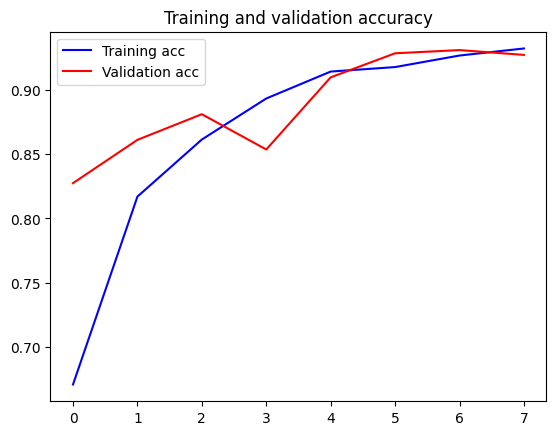

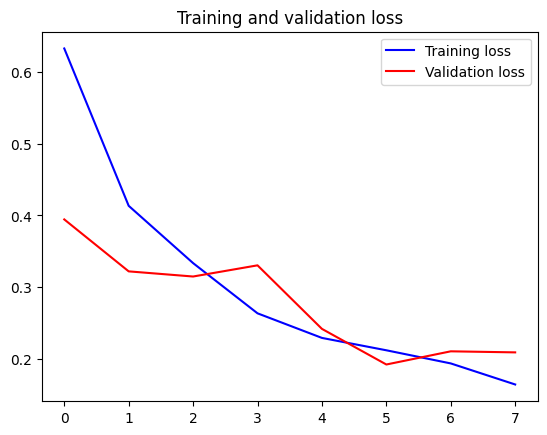

In [23]:
plot_training(transf_history)

# Transfer Learning: Graft a new head onto *an even shorter* prefix of VGG 16.
- Can we still learn ?

In [24]:
transf_model = createTransferModel(base_model, 'block3_pool')
transf_model.summary()

Last layer block3_pool is index 10
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50


<ipython-input-7-3bed2bd7014a>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


125/125 [==============================] - 17s 127ms/step - loss: 2.9498 - acc: 0.5195 - val_loss: 0.6872 - val_acc: 0.5775
Epoch 2/50
125/125 [==============================] - 17s 136ms/step - loss: 0.6942 - acc: 0.6050 - val_loss: 0.6289 - val_acc: 0.7925
Epoch 3/50
125/125 [==============================] - 16s 128ms/step - loss: 0.6555 - acc: 0.6120 - val_loss: 0.5778 - val_acc: 0.7937
Epoch 4/50
125/125 [==============================] - 16s 126ms/step - loss: 0.6638 - acc: 0.6585 - val_loss: 0.6925 - val_acc: 0.7450
Epoch 5/50
125/125 [==============================] - 17s 134ms/step - loss: 0.5853 - acc: 0.6735 - val_loss: 0.4891 - val_acc: 0.7663
Epoch 6/50
125/125 [==============================] - 16s 129ms/step - loss: 0.5784 - acc: 0.6955 - val_loss: 0.4531 - val_acc: 0.8150
Epoch 7/50
125/125 [==============================] - 16s 126ms/step - loss: 0.5226 - acc: 0.7345 - val_loss: 0.4688 - val_acc: 0.7862
Epoch 8/50
125/125 [==============================] - 17s 138ms/st

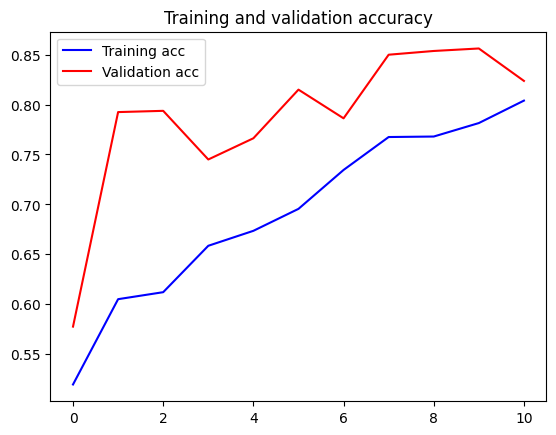

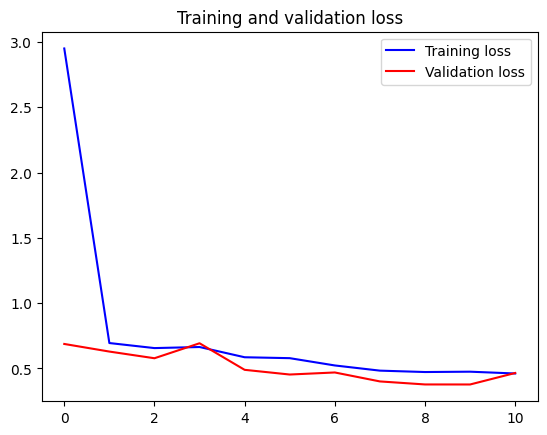

In [25]:
transf_history = trainModel(transf_model, train_data_dir, validation_data_dir)
plot_training(transf_history)